<a href="https://colab.research.google.com/github/mafsousa/CodeLab_Notebooks/blob/master/My_CellPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cellpose install dependencies



In [7]:
!pip install cellpose
#!pip uninstall mxnet-mkl -y
!pip install mxnet-cu101
!pip install memory_profiler
!pip install tifffile # contains tools to operate tiff-files


import numpy as np
import os, random
import shutil 
import zipfile
from tifffile import imread
from astropy.visualization import simple_norm

from pathlib import Path
import os
import pandas as pd
import csv

#cellpose specific
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import mxnet as mx
from cellpose import utils

use_GPU = utils.use_gpu()
print('GPU activated? %d'%use_GPU)

np.random.seed(42)


%load_ext memory_profiler
print("Libraries installed")

GPU activated? 0


NameError: ignored

In [5]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Default advanced parameters enabled
Loaded images (width, length) = (1024, 1024)
Parameters initiated.


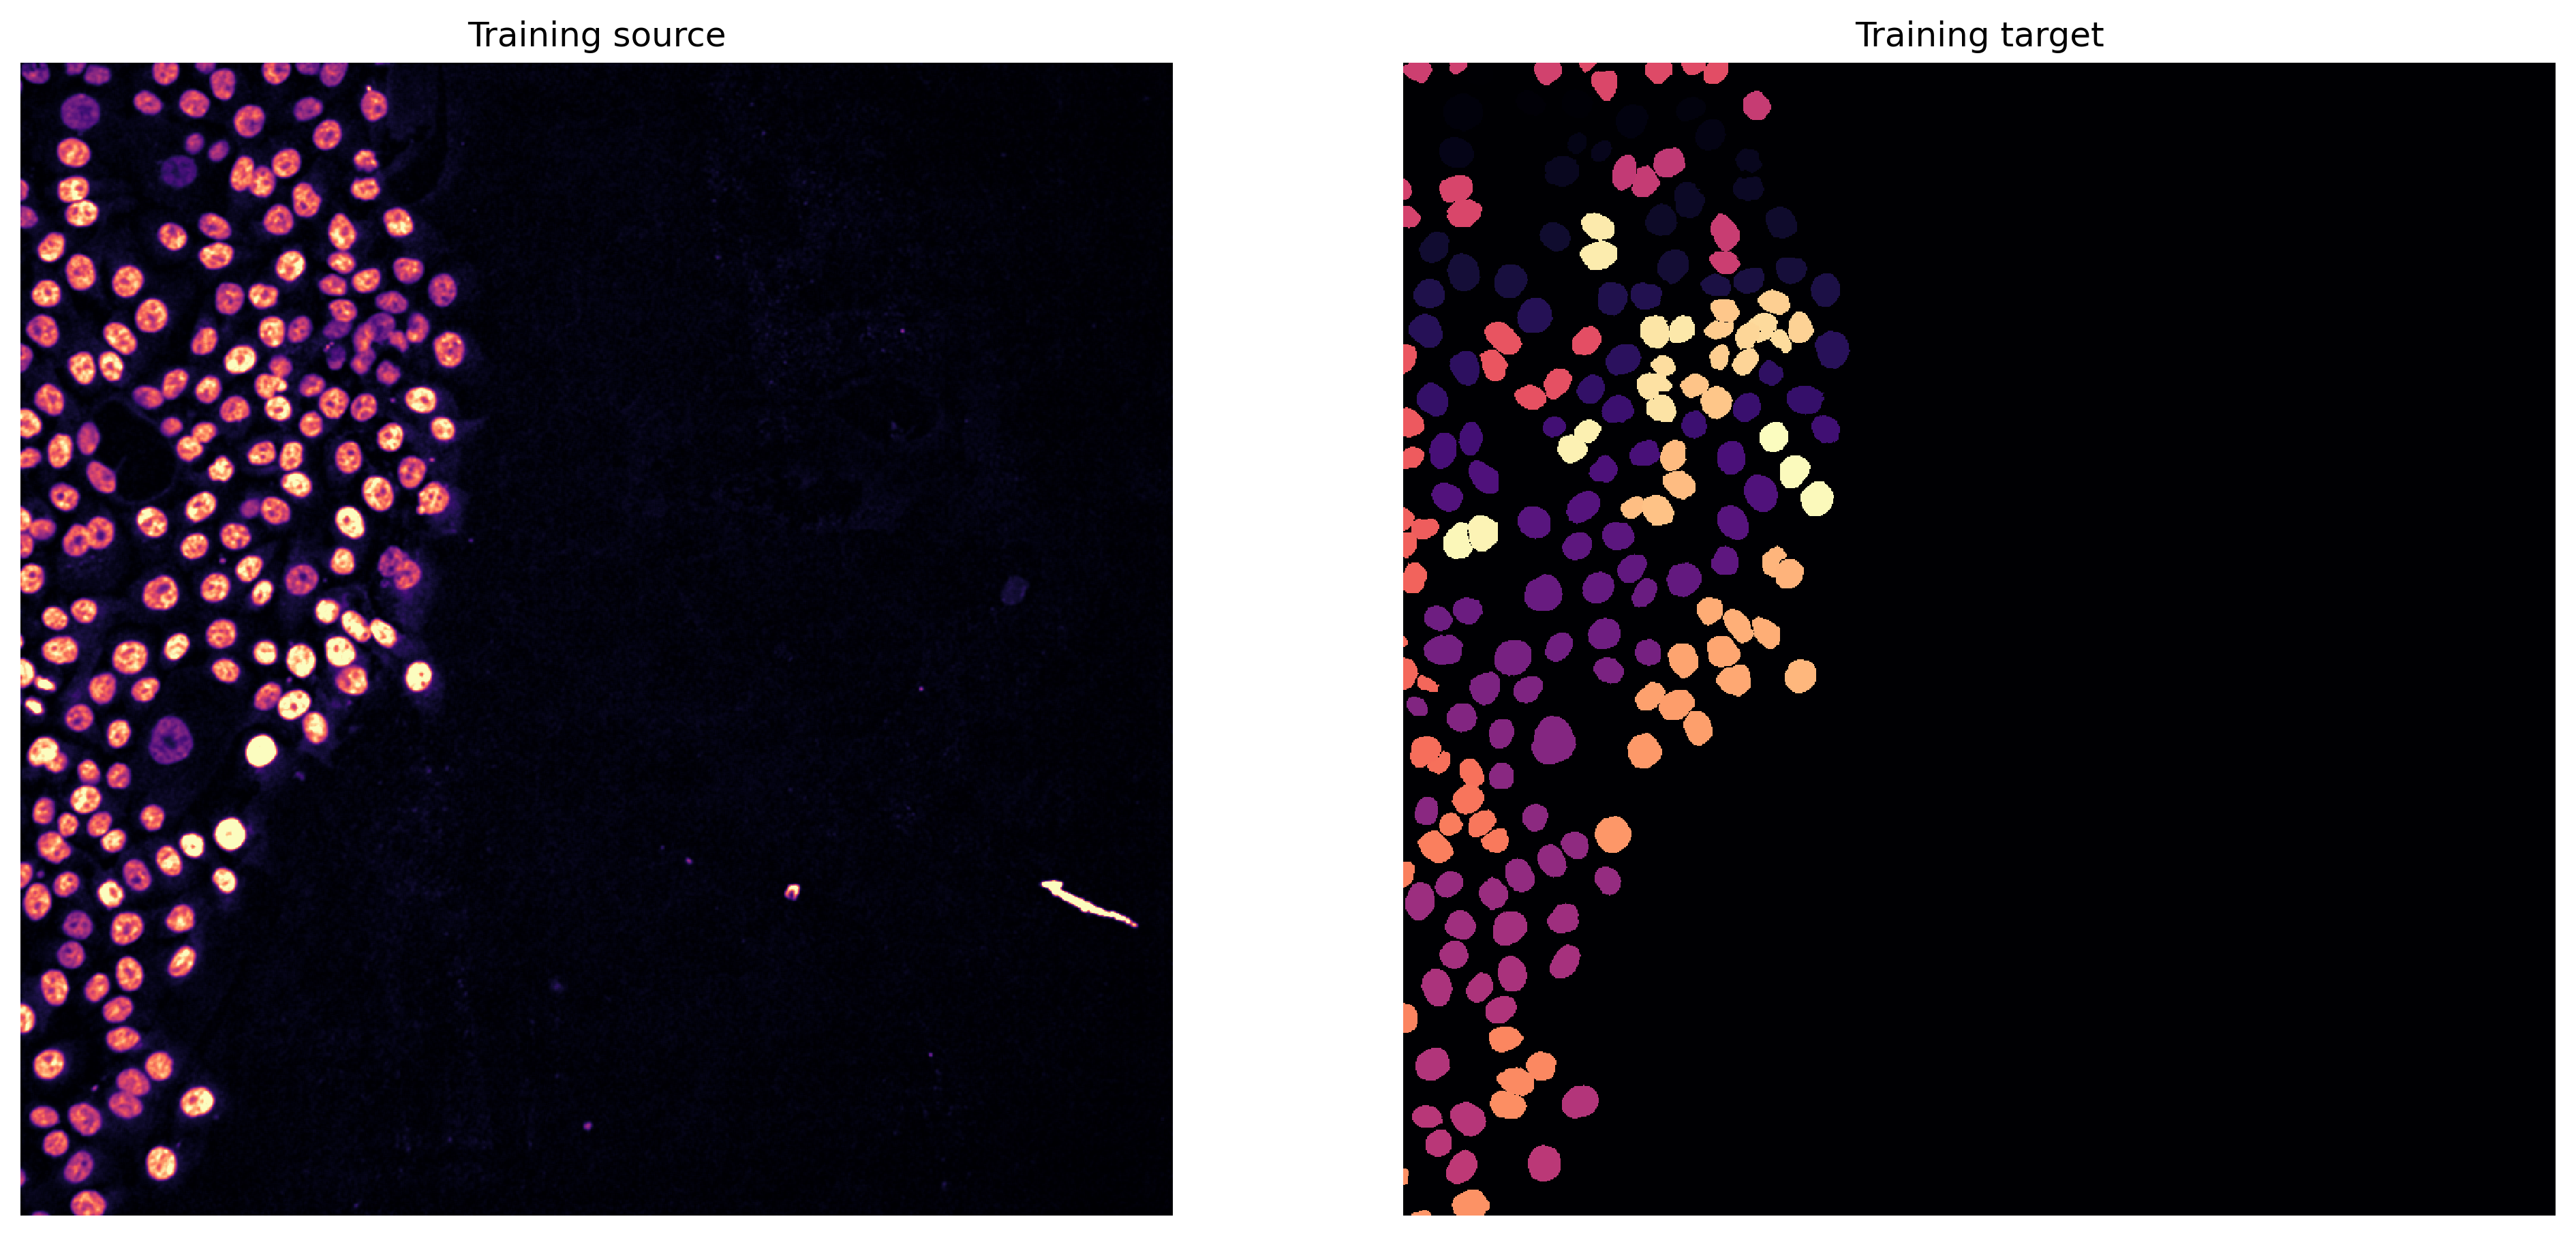

In [37]:
#@markdown ###Path to training images: 
Training_source = "/content/gdrive/My Drive/Colab Notebooks/My_cellpose/Training - Images" #@param {type:"string"}
training_images = Training_source


Training_target = "/content/gdrive/My Drive/Colab Notebooks/My_cellpose/Training - Masks" #@param {type:"string"}
mask_images = Training_target 


#@markdown ###Name of the model and path to model folder:
model_name = "cellpose_model" #@param {type:"string"}

model_path = "/content/gdrive/My Drive/Colab Notebooks/My_cellpose/Model" #@param {type:"string"}
#trained_model = model_path 


#@markdown ### Other parameters for training:
number_of_epochs =  100#@param {type:"number"}

#@markdown ###Advanced Parameters
Use_Default_Advanced_Parameters = True #@param {type:"boolean"}

#@markdown ###If not, please input:

#GPU_limit = 90 #@param {type:"number"}
number_of_steps = 37#@param {type:"number"}
patch_size = 1024 #@param {type:"number"}
batch_size = 2 #@param {type:"number"}
percentage_validation =  10 #@param {type:"number"}
n_rays = 32 #@param {type:"number"}
grid_parameter = 2#@param [1, 2, 4, 8, 16, 32] {type:"raw"}
initial_learning_rate = 0.0003 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  batch_size = 2
  n_rays = 32
  percentage_validation = 10
  grid_parameter = 2
  initial_learning_rate = 0.0003

percentage = percentage_validation/100

#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)
  
# Here we open will randomly chosen input and output image
random_choice = random.choice(os.listdir(Training_source))
x = imread(Training_source+"/"+random_choice)

# Here we check the image dimensions

Image_Y = x.shape[0]
Image_X = x.shape[1]

print('Loaded images (width, length) =', x.shape)

# If default parameters, patch size is the same as image size
if (Use_Default_Advanced_Parameters):
  patch_size = min(Image_Y, Image_X)
  
#Hyperparameters failsafes

# Here we check that patch_size is smaller than the smallest xy dimension of the image 

if patch_size > min(Image_Y, Image_X):
  patch_size = min(Image_Y, Image_X)
  print (bcolors.WARNING + " Your chosen patch_size is bigger than the xy dimension of your image; therefore the patch_size chosen is now:",patch_size)


# Here we check that the patch_size is divisible by 8
if not patch_size % 8 == 0:
    patch_size = ((int(patch_size / 8)-1) * 8)
    print (bcolors.WARNING + " Your chosen patch_size is not divisible by 8; therefore the patch_size chosen is:",patch_size)

# Here we disable pre-trained model by default (in case the next cell is not run)
Use_pretrained_model = False

print("Parameters initiated.")


os.chdir(Training_target)
y = imread(Training_target+"/"+random_choice)

#Here we use a simple normalisation strategy to visualise the image
norm = simple_norm(x, percent = 99)

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, interpolation='nearest', norm=norm, cmap='magma')
plt.title('Training source')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, interpolation='nearest', cmap='magma')
plt.title('Training target')
plt.axis('off');

Run cellpose with imported images

In [39]:

from cellpose import models
from glob import glob
from tifffile import imread, imsave

X = sorted(glob(training_images+"/*.tif"))   
print(X[0])
# Here we map the training dataset (images and masks).

X = list(map(imread,X))

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)

/content/gdrive/My Drive/Colab Notebooks/My_cellpose/Training - Images/H-G_T24_WT_a1_series_10_frame_1.tif
>>>> using CPU


FileNotFoundError: ignored

In [0]:
# DISPLAY RESULTS
from cellpose import plot
nimg = Training_source
nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()